📂 Upload ZIP file (Fake.csv + True.csv)


Saving real and fake dataset.zip to real and fake dataset (3).zip


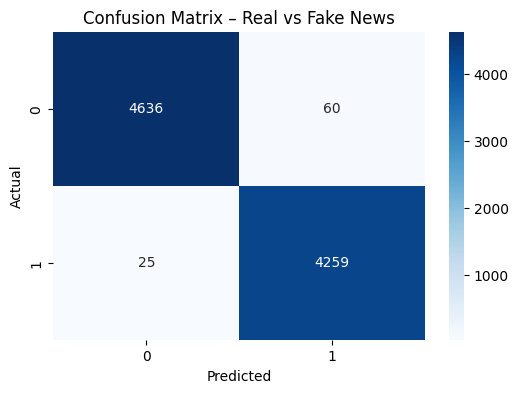

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://af7c08ed2e59b781d8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# 📌 REAL vs FAKE DATA DETECTION SYSTEM (FINAL – ENHANCED)
# ============================================================

!pip install gradio seaborn scikit-learn pytesseract pillow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, zipfile, io

from google.colab import files
from PIL import Image
import pytesseract

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import gradio as gr

# ============================================================
# 🔹 DATASET UPLOAD
# ============================================================
print("📂 Upload ZIP file (Fake.csv + True.csv)")
uploaded = files.upload()

zip_name = list(uploaded.keys())[0]
zf = zipfile.ZipFile(io.BytesIO(uploaded[zip_name]))

fake_df = pd.read_csv(zf.open("Fake.csv"))
true_df = pd.read_csv(zf.open("True.csv"))

fake_df["label"] = 0   # FAKE
true_df["label"] = 1   # REAL

df = pd.concat([fake_df, true_df]).reset_index(drop=True)
DATASET_SOURCE = "Fake and Real News Dataset (Kaggle)"

# ============================================================
# 🔹 TEXT CLEANING
# ============================================================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df.dropna(subset=["text"], inplace=True)
df["text"] = df["text"].apply(clean_text)

X = df["text"]
y = df["label"]

# ============================================================
# 🔹 TF-IDF + MODEL TRAINING
# ============================================================
tfidf = TfidfVectorizer(stop_words="english", max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=3000, class_weight="balanced")
model.fit(X_train, y_train)

# ============================================================
# 🔹 MODEL EVALUATION
# ============================================================
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Real vs Fake News")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, pred))

# ============================================================
# 🔹 DECISION LOGIC WITH COLOR
# ============================================================
def intensity_label(real_prob):
    if real_prob >= 0.55:
        return ("🟢 REAL DATA", "green")
    elif real_prob >= 0.40:
        return ("🟡 SUSPICIOUS DATA", "orange")
    else:
        return ("🔴 FAKE DATA", "red")

# ============================================================
# 🔹 TEXT INPUT PREDICTION
# ============================================================
def detect_text(text):
    if len(text.split()) < 25:
        return "⚠️ Please enter at least 25 words."

    text_clean = clean_text(text)
    vector = tfidf.transform([text_clean])
    probs = model.predict_proba(vector)[0]
    fake_prob = probs[0]
    real_prob = probs[1]

    label, color = intensity_label(real_prob)

    # Rich formatting with color
    result = f"<div style='color:{color}; font-weight:bold;'>Result: {label}</div>"
    result += f"<div>Real Probability: {real_prob:.2f}</div>"
    result += f"<div>Fake Probability: {fake_prob:.2f}</div>"
    result += f"<div>Data Source: {DATASET_SOURCE}</div>"

    return result

# ============================================================
# 🔹 SCANNED IMAGE (OCR) PREDICTION WITH EDITABLE TEXT
# ============================================================
def detect_image(image):
    if image is None:
        return ("❌ No image uploaded.\n"
                "Please upload a scanned news article or report.")

    extracted_text = pytesseract.image_to_string(Image.fromarray(image))
    if len(extracted_text.split()) < 20:
        return "❌ Scanned text unclear or too short."

    text_clean = clean_text(extracted_text)
    vector = tfidf.transform([text_clean])
    probs = model.predict_proba(vector)[0]
    fake_prob = probs[0]
    real_prob = probs[1]

    label, color = intensity_label(real_prob)

    result = f"<b>Extracted Text:</b>\n{extracted_text}\n\n"
    result += f"<div style='color:{color}; font-weight:bold;'>Result: {label}</div>"
    result += f"<div>Real Probability: {real_prob:.2f}</div>"
    result += f"<div>Fake Probability: {fake_prob:.2f}</div>"
    result += f"<div>Data Source: {DATASET_SOURCE}</div>"

    return result

# ============================================================
# 🔹 GRADIO INTERFACE
# ============================================================
text_ui = gr.Interface(
    fn=detect_text,
    inputs=gr.Textbox(lines=8, label="Enter News Text / Report"),
    outputs=gr.HTML(label="Prediction"),
    title="Real vs Fake Data Detection – Text"
)

image_ui = gr.Interface(
    fn=detect_image,
    inputs=gr.Image(label="Upload Scanned News"),
    outputs=gr.HTML(label="Prediction"),
    title="Real vs Fake Data Detection – OCR"
)

# ============================================================
# 🔹 ENHANCED PROJECT INFO
# ============================================================
info_text = """
📌 Project: Real vs Fake Data Detection System (Enhanced)

📂 Dataset Used:
Fake and Real News Dataset (Kaggle)

🧠 Methodology:
- Text preprocessing: lowercase, remove URLs & punctuation, strip extra spaces
- Feature extraction: TF-IDF (1-2 grams, max 5000 features)
- Model: Logistic Regression with class balancing
- Evaluation: Confusion Matrix, Classification Report

🎨 Color Intensity Key:
🟢 Green = High confidence Real
🟡 Yellow = Medium confidence / Suspicious
🔴 Red = High confidence Fake

🔍 Features:
- Predict on plain text input (≥25 words)
- Predict from scanned news articles using OCR (Pytesseract)
- Shows probabilities for Real & Fake
- Includes data source reference

💡 Notes:
- System is optimized for English news articles.
- Short or unclear text may not produce reliable predictions.
- Ideal for verifying news articles, reports, or social media content.
"""

info_ui = gr.Interface(
    fn=lambda: info_text,
    inputs=[],
    outputs=gr.Textbox(lines=20, label="Project Information", interactive=False),
    title="Project Information"
)

# ============================================================
# 🔹 LAUNCH TABBED INTERFACE
# ============================================================
app = gr.TabbedInterface(
    [text_ui, image_ui, info_ui],
    ["Text Input", "Scanned Image", "Project Info"]
)

app.launch()
